# Abstract

During this project we looked at the correlation between beer styles, ratings and geographical locations.  There are clearly some beer styles that are geographically influenced (such as a Munich Lager or Belgian Tripple or even a Kentucky Common), but are there certian types of beers that are better in particular geographies than others.  In order to look at this question, we will use the [Beer Advocate data set](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fdata.world%2Fsocialmediadata%2Fbeeradvocate).  Finally at the end of this project we will build a model that will help us to predict the best beer styles in a given location - to help answer the question "what kind of beer should I get when I travel to a particular place".

# Overview and Motivation

When it comes to beer coming from Europe, it is clear that there is a correlation between style and geography. This correlation is so significant that most styles are named after the location they come from. Examples of this are "Munich Lager" or "Belgian Tripple".

What isn't clear without doing some research is if this correlation applies to beers in the USA, and if the "best" versions of those geographically correlated beers come from those locations.

I would like to explore the question - are there specific geographies that lend themselves to certain types of beers. I believe that this will definitely hold true through Europe - where beer styles are very historically oriented to the location they come from, but don't know how well this will hold for American Breweries, with a few stylistic exceptions.

# Related Work

There have been several other works that have looked at components of beer ratings.  Two papers that I looked at to try and understnad work that had been done before are:


*   [Rating Predicion for Beer](https://jmcauley.ucsd.edu/cse255/projects/fa15/042.pdf) - a paper written by Xun Jiao and Zhou Fang for a UCSD Computer Science class in 2015 - which looks at some of the key apsects of the RateBeer data set - a similar dataset to the one we used, to see what controtibuted to beer ratings.  This also looked at the rating authors' impact to a given rating.  This project looked at the textual ratings as well as several other factors (like ABV) that are directly in the data set.
*   [From Amateurs to Connoisseurs: Modeling the Evolution of User Expertise through Oneline Reviews](https://paperswithcode.com/paper/from-amateurs-to-connoisseurs-modeling-the) - this is a paper written by Julian McAuley, Jure Leskovec at Stanford in March of 2013, looking at how reviewers' trends changed over time - also using the RateBeer data set.  They concluded that they could determine speicfic changes in users' tastes over time by analyizing their ratings over time.



## Dataset

In order to get to the bottom of this question, we need to have access to a wide range of beer reviews and the information about where those beers were brewed.  There were no readily available datasets with all this information, so a significant amount of work was put in to create this dataset.

I have chosen the BeerAdvocate reiew dataset which contains aproxamately 1.5 million individual beer reviews, collected from 2000 through 2011.  This dataset is available in several forms, the one used is a processed CSV file available here:

https://data.world/socialmediadata/beeradvocate

This dataset has the following fields:

* brewery_id - a unique identifier representing the brewery making the beer
* brewery_name - the name of the brewery making the beer
* review_time - the date/time of the review
* review_overall - the overall (numeric) score
* review_aroma - the score the reviewer gave the aroma of the beer
* review_appearance - the score the reviewer gave the appearance of the beer
* review_profilename - the username of the user doing the review
* beer_style - the style of beer (text)
* review_palate - the score the reviewer gave the palate of the beer
* review_taste - the score the reviewer gave the taste of the beer
* beer_name - the name of the beer
* beer_abv - the ABV of the beer
* beer_beerid - a unique ID for the beer

## Data Joining and Cleaning

I will have to augment this dataset, as the dataset only contains the ID of the brewer.  That makes converting this to a location more complicated.  I have extracted the IDs of the brewers of these beers, and there are 7547 unique brewers in the dataset.

For most of these brewers, information is available on the BeerAdvocate website with the location of the brewer, by using the URL:

> https://www.beeradvocate.com/beer/profile/${BREWER}/

I have extracted this information from the website and created another dataset with the City, State and Country information for each of these brewers, using the following script to find the place list code and parsing out the fields that we need into a CSV file:

~~~
#!/bin/zsh
if [ "$1" = "" ] ; then
  echo "usage: $0 file.html"
  exit 1
fi

dofile()
{
  file=$1
  rootname=${file%%.html}
  placefile=${rootname}.place

  #echo ${placefile}
  echo -n "${rootname},"
  grep /place/list ${file} | sed 's,.*/place/list/?,,;s,".*$,,;s;&;,;g;s;=;,;g;s,+, ,g' | perl -pne 's/%([A-Fa-f\d]{2})/chr hex $1/eg;' | tr -d '\n'
  echo ""
}

echo "brewery_id,,city,,country,,state,,"

while [ "$1" != "" ] ; do
  dofile $1
  shift
done

~~~

Unfortunately data was not availble for all brewers (likely because the data is a bit older, some of it isn't available any more).

Out of 7548 breweries, the location information was unavaialble from the BeerAdvocate web site for 1338 of those.

I did some manual cleanup to make sure the formats were correct via google sheets, and now have a CSV with the following columns:

* brewery_id - the ID from the previous file
* city - the city the brewery is in
* country - the country of the brewery
* state - the state of the brewery
* location - a string that is the location (city, country, state together)



In [ ]:
import pandas as pd

GOOGLE_API_KEY = '' # TODO: place your Google API key here
location_path='/content/drive/MyDrive/WPI/CS539/Data/final-project/breweries-cleaned.csv'

# Load the brewery location data and interpret blanks as strings, not NaN
brewery_location_data = pd.read_csv(location_path,keep_default_na=False)

print(brewery_location_data)


      Unnamed: 0.1  Unnamed: 0  brewery_id          city country          lat  \
0                0           0           1         Plzeň      CZ   49.7384314   
1                1           1           2   San Antonio    s_id   29.4251905   
2                2           2           3     Covington    s_id   30.4754702   
3                3           3           4      Portland            45.515232   
4                4           4           5        Yakima      US   46.6020711   
...            ...         ...         ...           ...     ...          ...   
7542          7542        7542       13923  Peterborough    s_id   44.3047061   
7543          7543        7543       13927     Anchorage    s_id   61.2175758   
7544          7544        7544       13933                                      
7545          7545        7545       13940      Canberra    s_id  -35.2801846   
7546          7546        7546       13946        Selden    s_id   40.8664873   

               lng         

Next we need to augment the textual representations of the locations with latitude/longitude data - since we'd like to use location as input to clustering altorithms.

That requires using a geocoding API. The following script augments the dataframe with lat/lng columns loaded from google's geocode API.

The script edits the file in place and only runs on rows that don't already have lat/lng set (and have a location column that isn't blank).

This let me run the script, clean up any columns that might have errors (for example the API had trouble with BE as the country for Belgium - so I updated those rows with the full country name, and they started working on the next pass).

In [ ]:
import datetime
import requests
import urllib.parse

querycount=0
querylimit=1000 # this can be expanded, but I know that I just have errors, so don't want to run up my bill when I run the notebook

brewery_location_data = pd.read_csv(location_path,keep_default_na=False)

def extract_lat_long_via_address(address_or_zipcode):
    lat, lng = None, None
    api_key = GOOGLE_API_KEY
    #print("Address for: " + str(address_or_zipcode))
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    endpoint = base_url + "?address=" + urllib.parse.quote_plus(address_or_zipcode) + "&key=" + urllib.parse.quote_plus(api_key)
    # see how our endpoint includes our API key? Yes this is yet another reason to restrict the key
    #print("Get: " + endpoint)
    r = requests.get(endpoint)
    if r.status_code not in range(200, 299):
        #print(r.status_code)
        return None, None
    try:
        '''
        This try block incase any of our inputs are invalid. This is done instead
        of actually writing out handlers for all kinds of responses.
        '''
        results = r.json()['results'][0]
        lat = results['geometry']['location']['lat']
        lng = results['geometry']['location']['lng']
        #print("Location for: " + address_or_zipcode + ": " + str(lat) + ", " + str(lng))
    except Exception as inst:
        print("Error getting location for: " + str(address_or_zipcode) + ": " + str(inst))
        pass
    return lat, lng

def enrich_with_geocoding_api(row):
    global querycount
    if querycount > querylimit:
      return row
    column_name = 'location'
    if (column_name not in row):
      return row

    address_value = row[column_name]
    # only enrich if we have a location and we don't have lat/lng already
    #print(address_value)

    if ( ( address_value != None and address_value != "" ) and
         ( ( 'lat' not in row and 'lng' not in row ) or
           ( row['lat'] == "" and row['lng'] == "" ) ) ):
      querycount=querycount+1
      address_lat, address_lng = extract_lat_long_via_address(address_value)
      row['lat'] = address_lat
      row['lng'] = address_lng

    return row

#brewery_location_data_with_location=brewery_location_data.apply(enrich_with_geocoding_api, axis=1)
#print(brewery_location_data_with_location)
#brewery_location_data_with_location.to_csv(location_path)

(Because of the way that the above function is written, even though we have some errors, we can fix them over time and continue to get better data, but for now, lets do some exploring)

Now that we have a fairly clean list of brewerys and locations, we should be able to merge those with the list of beer reviews, and know where the beers for each review were brewed.

We now have two major data sets to work with - a set of beer reviews that include brewery IDs, and a set of data about each brewery, including the location (City, State, Country) and Latitude and Longitude of the location.


# Research Question

As we explored the various information related to beer styles and location, we ended up with a final research question of:

> Does a correlation between the overall quality of beer in a given style (represented by overall rating in beer reviews per style) and the geography of the brewer exist?  While it appears that this correlation should exist historically in Europe, where beer styles were developed geographically, it is not obvious if the same conditions will appear in the USA - where styles were more “imported” with immigrants from Europe and most styles are not associated with a particular geographic location.


In this case our response variables are the geographic location of the brewery and the style of beer.  Our predictor variable is the expected quality of the beer - as represented by the overall review rating.

We then follow this with a more practical question (not just research related, but a model and code that will help us in the future) which is:

> Can I predict what kind of beer I should drink when I go to a specific location (like on vacation)



# Exploratory Data Analysis

Once we have our datasets, the first thing we need to do is merge our data.  This will give us a list of beer reviews, where each beer review contains a rating, a style, a brewery and a location.

In [ ]:
import pandas as pd
import numpy as np

# file locations
reviews_path='/content/drive/MyDrive/WPI/CS539/Data/final-project/beer_reviews.csv'
location_path='/content/drive/MyDrive/WPI/CS539/Data/final-project/breweries-cleaned.csv'


# Load the BeerAdvocate data
beer_reviews = pd.read_csv(reviews_path)

# Load the brewery location data
brewery_location_data = pd.read_csv(location_path)
# Use the `replace()` function to remove blank strings
brewery_location_data['lat'] = brewery_location_data['lat'].replace(' ', np.nan, regex=True)
brewery_location_data['lng'] = brewery_location_data['lng'].replace(' ', np.nan, regex=True)
brewery_location_data.lat = brewery_location_data.lat.astype(float)
brewery_location_data.lng = brewery_location_data.lng.astype(float)


# Merge the two datasets
merged_data = pd.merge(beer_reviews, brewery_location_data, on='brewery_id')

# Clean the data
merged_data.dropna(inplace=True,subset=['review_overall','beer_style','lat', 'lng'])

print(merged_data)

         brewery_id                  brewery_name  review_time  \
0             10325               Vecchio Birraio   1234817823   
1             10325               Vecchio Birraio   1235915097   
2             10325               Vecchio Birraio   1235916604   
3             10325               Vecchio Birraio   1234725145   
4              1075       Caldera Brewing Company   1293735206   
...             ...                           ...          ...   
1101490        6785          Brauerei Lasser GmbH   1168021510   
1101491        6785          Brauerei Lasser GmbH   1082412767   
1101492        6785          Brauerei Lasser GmbH   1091652403   
1101493        6102  Georg Meinel Bierbrauerei KG   1297373426   
1101494        6102  Georg Meinel Bierbrauerei KG   1301531398   

         review_overall  review_aroma  review_appearance review_profilename  \
0                   1.5           2.0                2.5            stcules   
1                   3.0           2.5            

As you can see we have 21 various features for each row, and just over one 1M beer reviews.

## Basic Data Characteristics

Lets first take a look at some basic statistics about the data, and explore some histograms (though we'll need to look in more detail at most of these)


array([[<Axes: title={'center': 'brewery_id'}>,
        <Axes: title={'center': 'review_time'}>,
        <Axes: title={'center': 'review_overall'}>,
        <Axes: title={'center': 'review_aroma'}>],
       [<Axes: title={'center': 'review_appearance'}>,
        <Axes: title={'center': 'review_palate'}>,
        <Axes: title={'center': 'review_taste'}>,
        <Axes: title={'center': 'beer_abv'}>],
       [<Axes: title={'center': 'beer_beerid'}>,
        <Axes: title={'center': 'Unnamed: 0.1'}>,
        <Axes: title={'center': 'Unnamed: 0'}>,
        <Axes: title={'center': 'lat'}>],
       [<Axes: title={'center': 'lng'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

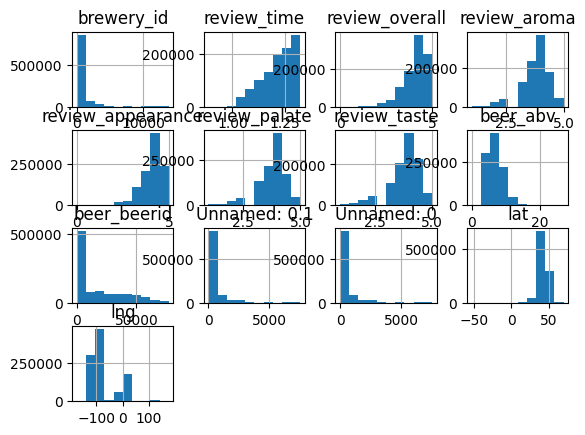

In [ ]:
merged_data.shape

merged_data.hist()

Since we're looking at geographical relations of beer styles to review ratings, lets try and take a look at that now by running a scatter plot that shows latitude/longitude vs overall rating:

(-180.0, 180.0)

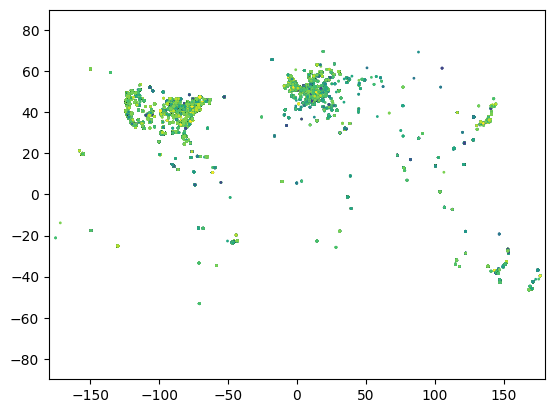

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x=merged_data.lng
y=merged_data.lat


score=merged_data.review_overall
plt.scatter(x, y, s=1, c=score)
plt.ylim(-90,90)
plt.xlim(-180,180)

As you can see, this somewhat correlates to a world map.  You can see a concentration of reviews in the USA and Europe.  There are a few outside of those major locations, but mostly in the same place.


One aspect that we will also look at as we move forward would be to actually try and see if there are differences in how the model works in the USA vs in Europe - since these are the two most significant geographical areas with data.

## Rating information

We talked about looking at ratings - lets see what the ratings look like overall.

array([[<Axes: title={'center': 'review_overall'}>]], dtype=object)

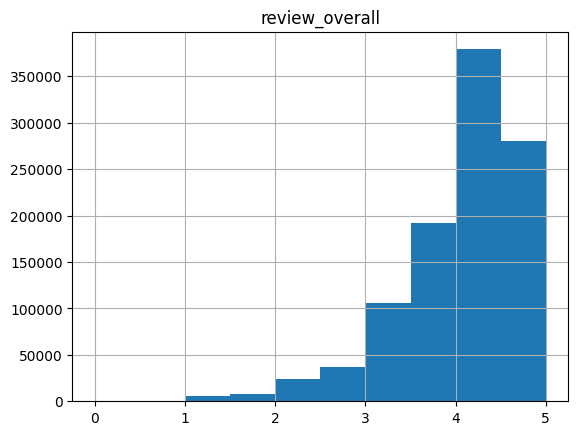

In [ ]:
merged_data.hist(column='review_overall', bins=10)

It turns out that there are only 10 unique ratings (this dataset has rating granularity of .5 on a scale of 1-5).  And it also seems like generally people like beer a lot!  As you can see the most frequent rating is a 4.5.

## Style Information

We're also interested in beer style information here as well.  So lets take a look at the number of beer styles and how many reviews each one has:

beer_style
American IPA                      75304
American Double / Imperial IPA    51118
American Pale Ale (APA)           38454
Russian Imperial Stout            37542
American Porter                   30786
                                  ...  
English Pale Mild Ale               460
Roggenbier                          283
Happoshu                            236
Sahti                               232
Kvass                               188
Name: count, Length: 104, dtype: int64


<BarContainer object of 104 artists>

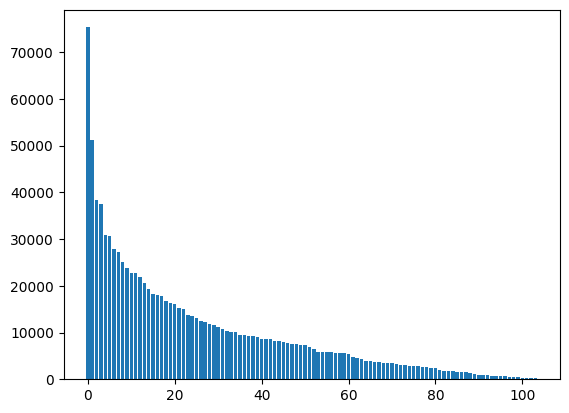

In [ ]:
style_counts = merged_data['beer_style'].value_counts()
print(style_counts)

plt.bar(x=range(style_counts.values.size), height=style_counts.values)

So it looks like we have about 104 styles. We have a LOT of data on the most common styles, and a lot less on some of the less frequent styles. We may have to make a cut around 80 styles - since seems like where we would have a few thousand reviews per style.

OK. Lets see if there are some styles that are more highly rated than others.

                     beer_style  review_overall  count
0                       Altbier        3.846462   5624
1        American Adjunct Lager        3.048155  23798
2      American Amber / Red Ale        3.832342  30586
3    American Amber / Red Lager        3.597851   5723
4           American Barleywine        3.923794  19244
..                          ...             ...    ...
99                 Vienna Lager        3.791584   7569
100                  Weizenbock        4.040770   7996
101                   Wheatwine        3.792753   2608
102               Winter Warmer        3.728796  12321
103                     Witbier        3.759774  18160

[104 rows x 3 columns]


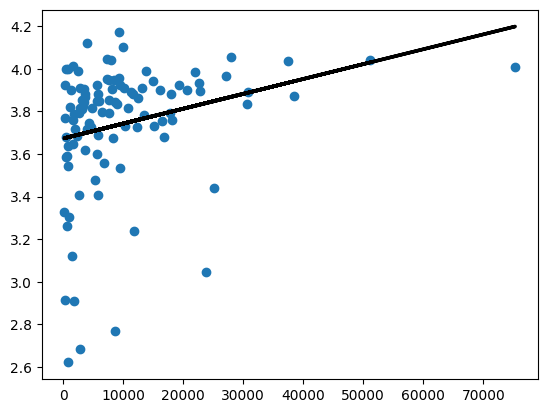

In [ ]:
style_ratings = merged_data.pivot_table('review_overall', index=['beer_style'],aggfunc='mean').copy()
df_style_count = style_counts.to_frame(name='count').reset_index(names=['beer_style'])

style_count_rating = pd.merge(style_ratings, df_style_count, on='beer_style')
print(style_count_rating)

xdata = style_count_rating['count']
ydata = style_count_rating['review_overall']
plt.scatter(x=xdata, y=ydata)
m, b = np.polyfit(xdata, ydata, 1)
# adding the regression line to the scatter plot
plt.plot(xdata, m*xdata + b, color="k", lw=2.5)

What I think this means is that various styles have very different average ratings. So we are going to need to create weighted ratings if we want to compare a given location's beers of one style to the average of a particular beer of another style.



## TODO - explore the variance of reviews across the same beer - to see if much of the variance is actually based on the reviewer, not the beer.

Since we're looking at various things, lets take a look at the number of different brewers:


brewery_id
35       39444
147      33066
140      28751
287      25191
132      24083
         ...  
5812         1
11142        1
7319         1
6225         1
3215         1
Name: count, Length: 2280, dtype: int64


<BarContainer object of 2280 artists>

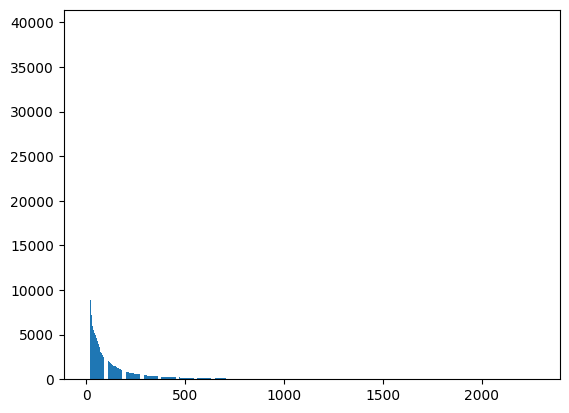

In [ ]:
brewers = merged_data['brewery_id'].value_counts()
print(brewers)

plt.bar(x=range(brewers.values.size), height=brewers.values)

So we have a LOT more breweries. Seems like if we were really focusing on breweries, we'd be looking at somewhere between 500 and 750 where we have enough reviews to do something with.

What happens if we grouped our reviews by brewer, and computed the average rating by brewer, and then plotted that on a map - would get any more info?

   brewery_id  review_overall  Unnamed: 0.1  Unnamed: 0         city country  \
0           1        3.820192             0           0        Plzeň      CZ   
1           2        3.162500             1           1  San Antonio    s_id   
2           3        3.558802             2           2    Covington    s_id   
3           4        4.059555             3           3     Portland     NaN   
4           5        3.652473             4           4       Yakima      US   

         lat         lng               location state  
0  49.738431   13.373637              Plzeň, CZ   NaN  
1  29.425190  -98.494592  San Antonio, TX, s_id    TX  
2  30.475470  -90.100911    Covington, LA, s_id    LA  
3  45.515232 -122.678385               Portland   NaN  
4  46.602071 -120.505899         Yakima, WA, US    WA  


(-180.0, 180.0)

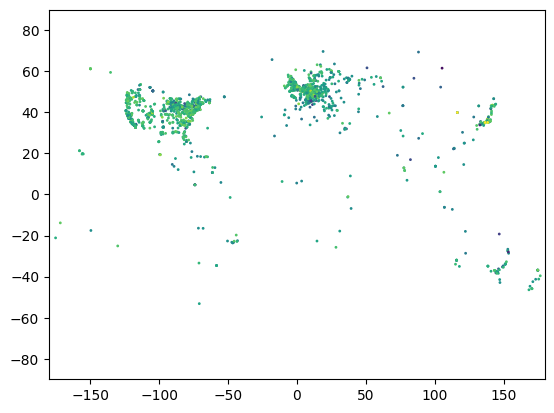

In [ ]:
import matplotlib.cm as cm

mean_ratings = merged_data.pivot_table('review_overall', index=['brewery_id'],aggfunc='mean')
mean_ratings[:5]
# = mean_ratings
# Merge the two datasets
brewery_location_ratings = pd.merge(mean_ratings, brewery_location_data, on='brewery_id')
print(brewery_location_ratings[:5])

x=brewery_location_ratings['lng']
y=brewery_location_ratings['lat']
score=brewery_location_ratings['review_overall']

#plt.scatter(x, y, c=score, s=1, cmap=cm.RdYlGn)
plt.scatter(x, y, c=score, s=1)
plt.ylim(-90,90)
plt.xlim(-180,180)

We see a bit of a different color scheme - and what appers to be lower overall ratings when we do this vs the map of the individual reviews that we did above.

# Model Revision

## Feature Engineering - Location

In order to answer this question, the first thing we need to do is understand how we handle geographic locations.  While we could take a naive view of location and just use City, State, Country information.  The challenge here is that there are some states (take Massachusetts for example) that have hundreds of breweries represented in a small area, while there are others (such as Idaho) that have significantly fewer breweries represented in a much larger area, or California that has close to a thousand breweries represented in a very large area.  This representation also misses any correlation between states (such as Massachusetts and Connecticut might share characteristics), or any geographical locations that might blur state lines.  Additionally, states are harder to represent in Europe, leading this method to be problematic.

Instead, I have determined that using clustering to be a useful method for turning geographical location into categorical data.  I have used K-means clustering to analyze the breweries and bucket them into a set of categories.  We can then use this same K-means classifier to later determine which geographical region a given prediction request should belong in.  

I started with the sqrt of the number of breweries as the value of K.  I found that this value (about 86 global regions) led to less than ideal predictions.  While I still need to run a full analysis, I reached the following formula as a good starting point:

~~~
clusters = int(math.sqrt(brewery_location_data.shape[0]))*4
~~~


In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn.cluster import KMeans


# file locations
reviews_path='/content/drive/MyDrive/WPI/CS539/Data/final-project/beer_reviews.csv'
location_path='/content/drive/MyDrive/WPI/CS539/Data/final-project/breweries-cleaned.csv'


# Load the BeerAdvocate data
beer_reviews = pd.read_csv(reviews_path)

# Load the brewery location data
brewery_location_data = pd.read_csv(location_path)
# Use the `replace()` function to remove blank strings
brewery_location_data['lat'] = brewery_location_data['lat'].replace(' ', np.nan, regex=True)
brewery_location_data['lng'] = brewery_location_data['lng'].replace(' ', np.nan, regex=True)
brewery_location_data.lat = brewery_location_data.lat.astype(float)
brewery_location_data.lng = brewery_location_data.lng.astype(float)
brewery_location_data.dropna(inplace=True,subset=['lat','lng'])

# before we merge, letes use kmeans clustering on the breweries to determine our geoclusters
# https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/
# tried a few different versions here, started with the sqrt of # of breweries
# right now, we are using the sqrt of the number of breweries * 4
clusters = int(math.sqrt(brewery_location_data.shape[0])) * 4
print("Using clusters: " , clusters)
geocluster_kmeans = KMeans(n_clusters = clusters, random_state = 0, n_init='auto')
# no need to normalize since lat/lng are same scale
#norm_data=preprocessing.normalize()
#brewery_location_data['geolabel']=geocluster_kmeans.fit_predict(brewery_location_data[['lat', 'lng' ]])

# Merge the two datasets
merged_data = pd.merge(beer_reviews, brewery_location_data, on='brewery_id')

# Clean the data
merged_data.dropna(inplace=True,subset=['review_overall','beer_style','lat', 'lng'])

print(merged_data.shape)

Using clusters:  312
(1032744, 21)


This gives us 312 different location groups, which the various breweries are grouped into.  Any new beer review or style that we would be predicting would end up in one of these clusters.

## Feature Engineering - Normalized Rating

One aspect that was looked at was if it made sense to try and normalize ratings across all styles.  That way a beer style that generally wasn't rated highly could be chosen as a desired beer even if the other more generally higher rated beers were in a given location.

We tried using standard rating that was defined as the distance from the mean rating of the style:

```
def normalize_rating(style_ratings,row):
  beer_style=row['beer_style']
  stylestd=float(style_ratings.loc[beer_style][('review_overall','std')])
  stylemean=float(style_ratings.loc[beer_style][('review_overall','mean')])
  review=row['review_overall']
  return (review-stylemean) / stylestd
  
def normalize_rating_by_style(data):

  style_ratings = data.groupby(['beer_style']).agg({'review_overall': [np.std, np.mean]}).copy()
  data['stdrating'] = data.apply(lambda x: normalize_rating(style_ratings,x), axis=1)

```

This however didn't seem to lead to data that was any more useful. so instead we contined to look at the overall rating.

After looking at this possibility, it turns out that it really isn't helpful at all.

## Model Construction

Our overall model construction for predicting a given rating for a given style in a given location, is based on a DecisionTreeRegressor

As part of the analysis I have looked at various Regression models.  So far, I have tested a RandomForestRegressor, DecisionTreeRegressor and HistGradientBoostingRegressor.

Answering the question: which beer style should I drink when I go to a given location, becomes a bit more complicated.  First we determine the location of where we are going.  Then we prepare an input dataset of all styles that we want to evaluate (more on this later) with the given latitude and longitude.  We then run this dataset through our geocoding model to determine the correct cluster.  We then run the same dataset through our Label Encoder to convert from textual to numeric style IDs.

This is then fed into our prediction model.  We use this model to predict the rating of each style of beer in the given location.  We can then use this list, and sort it and return the top beer styles that we should try in the given location.

So far the RandomForestRegresor with n_estimators set to 100 seems to give the best performance (based on RMS, R2 and Adjusted R2).





In [ ]:
from sklearn import preprocessing

# lets change the data to include an integer that indicates the style too
allstyles = merged_data['beer_style'].unique()
style_encoder = preprocessing.LabelEncoder()
style_encoder.fit(allstyles)

# create numeric styles
merged_data['beer_style_id'] = style_encoder.transform(merged_data['beer_style'])


Performance Evaluation
In order to evaluate the model that we’ve created I have tried to create a second model that does not take location into account - just predicting the rating based on beer style itself, instead of on geolocation and beer style. This should tell us how significantly the location factors into predicting the beer style.

In order to evaluate this, I will split the dataset 80/20 and run test data through both predictors, and then evaluate the RMS error and R2 score for each. This will help us decide which models to pick, as well as what hyperparameters to use.

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.cluster import KMeans
from sklearn import preprocessing
import pandas as pd
import numpy
import math

model_columns=['beer_style_id', 'geolabel']
target_column='review_overall'

def performance_test(X_train, X_test, y_train, y_test, location_classifier, model):
  # Lets first apply our location_classifier - tried to use a pipeline for this,
  # but I was having lots of problems, so we'll do this manually for now
  X_train=X_train.copy()
  X_test=X_test.copy()
    X_train['geolabel']=location_classifier.predict(X_train[['lat','lng']])
    X_test['geolabel']=location_classifier.predict(X_test[['lat','lng']])
    model_columns = std_columns + ['geolabel']

  # ok, we now can create a model
  # now lets test and see if its more accurate than just guessing the style
  model = model.fit(X_train[model_columns], y_train)
  y_predictions = model.predict(X_test[model_columns])

  classifier2 = RandomForestRegressor()
  #X_train['beer_style_id'] = style_encoder.transform(X_train['beer_style'])
  #classifier2 = classifier2.fit(X_train[['beer_style_id','lat','lng']], y_train)
  #y_predictions2 = classifier2.predict(X_test[['beer_style_id','lat','lng']])
  classifier2 = classifier2.fit(X_train[std_columns], y_train)
  y_predictions2 = classifier2.predict(X_test[std_columns])

  rms1 = mean_squared_error(y_test, y_predictions, squared=False)
  rms2 = mean_squared_error(y_test, y_predictions2, squared=False)

  r1=r2_score(y_test, y_predictions)
  r2=r2_score(y_test, y_predictions2)

  r2_adj1=1-(1-r1)*((len(X_test)-1)/(len(X_test)-X_test.shape[1]-1))
  r2_adj2=1-(1-r2)*((len(X_test)-1)/(len(X_test)-X_test.shape[1]-1))

  print("RMS/R2/AdjR2 with GeoCluster: ", rms1, r1, r2_adj1, " RMS/R2/AdjR2 without GeoCluster: ", rms2, r2, r2_adj2)
  print("percent of stddev explained with geo: ", 1-math.sqrt(1-r1), " vs without: ", 1-math.sqrt(1-r2))




In [ ]:

X=merged_data.copy()
Y=X[target_column]
X_train, X_test, y_train, y_test = train_test_split(X[['lat','lng','beer_style','beer_style_id',target_column]], Y, test_size=0.2, random_state=1)

print("RandomForestRegressor")
performance_test(X_train, X_test, y_train, y_test, geocluster_kmeans, RandomForestRegressor(n_estimators=100, random_state=0))
print("DecisionTreeRegressor")
performance_test(X_train, X_test, y_train, y_test, geocluster_kmeans, DecisionTreeRegressor())
print("HistGradientBoostingRegressor")
performance_test(X_train, X_test, y_train, y_test, geocluster_kmeans, HistGradientBoostingRegressor())


RandomForestRegressor
RMS/R2/AdjR2 with GeoCluster:  0.640875210516584 0.19892223503365714 0.19889896389950623  RMS/R2/AdjR2 without GeoCluster:  0.6733354676658266 0.11571814432512406 0.11569245613030632
percent of stddev explained with geo:  0.10497052285059183  vs without:  0.05963738075417102
DecisionTreeRegressor
RMS/R2/AdjR2 with GeoCluster:  0.6414629075048168 0.19745234871242834 0.1974290348784008  RMS/R2/AdjR2 without GeoCluster:  0.673332222834319 0.11572666708636548 0.11570097913913213
percent of stddev explained with geo:  0.10414976068118864  vs without:  0.05964191240058214
HistGradientBoostingRegressor
RMS/R2/AdjR2 with GeoCluster:  0.6542882635119386 0.16503938295809195 0.16501512753448688  RMS/R2/AdjR2 without GeoCluster:  0.673330788394775 0.11573043472213973 0.11570474688435539
percent of stddev explained with geo:  0.0862382055251445  vs without:  0.059643915701153016


As you can see the performance is quite similar across the various types of training models, but the RandomForestRegressor performs slightly better.

## Model Revision - Different ways of computing Geocluster

Instead of just using KMeans clustering, perhaps there is a different clustering algorithm that will work better for determining our geolabel feature.

We already tested KMeans, lets also test the other clustering algorithms that support prediction (not all do, many will only do fit_predict, which would mean we can't use them for our intended purpose).

We will test:
* Affinity Propogation
* BIRCH
* MeanShift


In [ ]:
# OK, lets create various geocluster models first
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import Birch
from sklearn.cluster import MeanShift

print("AffinityPropagation")
geocluster_affinity = AffinityPropagation(damping = 0.9, max_iter = 1000, random_state=0)
geocluster_affinity.fit(brewery_location_data[['lat', 'lng' ]])
performance_test(X_train, X_test, y_train, y_test, geocluster_affinity, RandomForestRegressor(n_estimators=100, random_state=0))

print("Birch")
geocluster_birch = Birch(n_clusters=clusters)
geocluster_birch.fit(brewery_location_data[['lat', 'lng' ]])
performance_test(X_train, X_test, y_train, y_test, geocluster_birch, RandomForestRegressor(n_estimators=100, random_state=0))

print("MeanShift")
geocluster_meanshift = MeanShift()
geocluster_meanshift.fit(brewery_location_data[['lat', 'lng' ]])
performance_test(X_train, X_test, y_train, y_test, geocluster_meanshift, RandomForestRegressor(n_estimators=100, random_state=0))


AffinityPropagation
RMS/R2/AdjR2 with GeoCluster:  0.6568671172237952 0.1584444771086012 0.1584200301044213  RMS/R2/AdjR2 without GeoCluster:  0.6733326475145627 0.11572555163838838 0.11569986365875151
percent of stddev explained with geo:  0.08263664620206312  vs without:  0.05964131930331418
Birch
RMS/R2/AdjR2 with GeoCluster:  0.6448564451665841 0.18893843570692026 0.18891487454557898  RMS/R2/AdjR2 without GeoCluster:  0.6733343147530901 0.1157211725302022 0.1156954844233532
percent of stddev explained with geo:  0.09941043516312065  vs without:  0.05963899088180091
MeanShift
RMS/R2/AdjR2 with GeoCluster:  0.6676287291743209 0.13064378167986956 0.13061852707155786  RMS/R2/AdjR2 without GeoCluster:  0.673332775675974 0.11572521501466304 0.11569952702524733
percent of stddev explained with geo:  0.06760726176137  vs without:  0.059641140316455066


So it seems like our KMeans clustering along with our RandomForestRegressor are the best model for our purposes at this point.

## Possible Model Revision - Removing the Individual Reviewer Bias

One aspect that we will be exploring for our final milestone is to determine how much the variance that we see in beer ratings is actually just normal variance across multiple users.  First, we will try and see if for a given beer and style if the RMS is high in general.  If we see that for the same beer we have high error rates - we will likely know that either the beer is changing a lot (unlikely) or that the reviewers have different tastes (as we discussed in the related papers information, this does seem to be true).

I'd like to see if by reducing the resolution of our data by averaging the reviews across brewery, beer ID (so you still might have multiple styles from the same brewery, but only one score per beer) if we might actually improve both the perofrmance of our model (by making it be able to tune more rapidly) and remove some of the error - what we really care about is the average score per beer, not predicting the individual score by beer anyway.

In [ ]:
individual_drop = ['review_overall', 'review_time', 'review_aroma', 'review_appearance', 'review_profilename', 'review_palate', 'review_taste', 'Unnamed: 0.1', 'Unnamed: 0']

merged_beer_ratings = merged_data.pivot_table('review_overall', index='beer_beerid', aggfunc='mean')
print(merged_data['beer_beerid'].unique().size, " unique beers")
print(merged_beer_ratings.shape, " beer ratings")

indiviual_beers = merged_data.copy()
individual_beers = indiviual_beers.drop(individual_drop, axis=1)
print(individual_beers['beer_beerid'].unique().size, " unique beers")

individual_beers.drop_duplicates(inplace=True)
print(individual_beers.shape)
individual_beers.reset_index(inplace=True, drop=True)

merged_beer_ratings.reset_index(names='beer_beerid',inplace=True)
print(individual_beers['beer_beerid'].unique().size, " unique beers")

individual_beers = individual_beers.merge(merged_beer_ratings, on='beer_beerid')
print(individual_beers.shape)
#individual_beers.dropna(inplace=True)
print(individual_beers.shape)

32081  unique beers
(32081, 1)  beer ratings
32081  unique beers
(32081, 13)
32081  unique beers
(32081, 14)
(32081, 14)


(-180.0, 180.0)

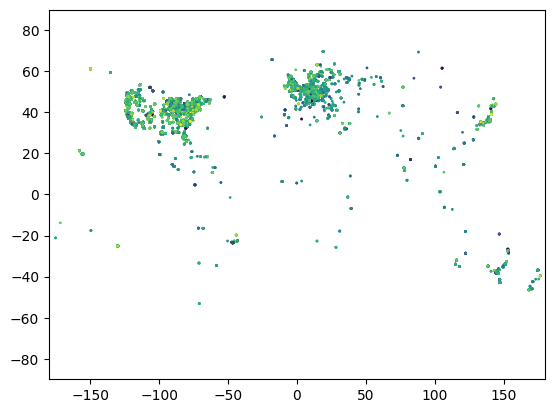

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x=individual_beers.lng
y=individual_beers.lat

score=individual_beers.review_overall
plt.scatter(x, y, s=1, c=score)
plt.ylim(-90,90)
plt.xlim(-180,180)

In [ ]:
from sklearn.model_selection import train_test_split
target_column='review_overall'
X=individual_beers.copy()
Y=X[target_column]
X_train, X_test, y_train, y_test = train_test_split(X[['lat','lng','beer_style','beer_style_id']], Y, test_size=0.2, random_state=1)

print("RandomForestRegressor")
performance_test(X_train, X_test, y_train, y_test, geocluster_kmeans, RandomForestRegressor(n_estimators=100, random_state=0))


RandomForestRegressor
RMS/R2/AdjR2 with GeoCluster:  0.6241606512118781 0.04635033449490822 0.045606574032027836  RMS/R2/AdjR2 without GeoCluster:  0.5919408637759663 0.14226578898932052 0.14159683390352207
percent of stddev explained with geo:  0.023450121342953767  vs without:  0.07386058770254278


What becomes super interesting in this case is that we perform worse than we did before.  One possibility is that since we just have less data now (~32k ratings vs ~1M ratings), so the model just can't be trained as well as it could before.  Either way, I think we will pass up this option.

## Overall Model Performance

So, what we've seen so far is that the model does help make our predictions better than they are just based on beer style alone.  

We saw the following metrics:

| Metric | Value With GeoCluster | Value with Base Model |
| --- | --- | --- |
| RMS | 0.640875210516584 |  0.6733354676658266 |
| R2 | 0.19892223503365714 |  0.11571814432512406 |
| Adj R2 | 0.19889896389950623 |  0.11569245613030632 |
| Pct StdDev Explained | 10.5% | 6% |

So, our geolabel based model performed almost twice as well as our base model.  Now that still might not be as good as we would like, and I have to admit that I'm somewhat surprised by the fact that geolocation only effects the rating a little bit, but the data is what it is.


### Additional Question - EU vs USA

As mentioned earlier - this evaluation will be run across both the EU dataset and the USA dataset.

This will tell us is geography is more important when it comes to beer style rating in the US vs the EU

In [ ]:
# for the purposes of this first model, lets limit ourselves to US based ratings
us_ratings = merged_data[(merged_data['lat'] > 24.396308)&
                        (merged_data['lat'] < 49.384358) &
                        (merged_data['lng'] > -125.0) &
                        (merged_data['lng'] < -66.93457)].copy()
# The bounding box around the continental United States is approximately between
# 24.396308 to 49.384358 degrees latitude in the north, and
# -125.0 to -66.93457 degrees longitude in the west.

eu_ratings = merged_data[(merged_data['lat'] > 35)&
                        (merged_data['lat'] < 75) &
                        (merged_data['lng'] > -10.0) &
                        (merged_data['lng'] < 40)].copy()

# we are using a bounding box of -10W to 40E and 35 to 75 north for EU
# That will capture ireland and all of western europe and northern europe.
# It excludes much of russia

print("US Rating Model")

X=us_ratings.copy()
Y=X[target_column]
X_train, X_test, y_train, y_test = train_test_split(X[['lat','lng','beer_style','beer_style_id',target_column]], Y, test_size=0.2, random_state=1)

performance_test(X_train, X_test, y_train, y_test, geocluster_kmeans, RandomForestRegressor(n_estimators=100, random_state=0))

print("EU Rating Model")

X=eu_ratings.copy()
Y=X[target_column]
X_train, X_test, y_train, y_test = train_test_split(X[['lat','lng','beer_style','beer_style_id',target_column]], Y, test_size=0.2, random_state=1)

performance_test(X_train, X_test, y_train, y_test, geocluster_kmeans, RandomForestRegressor(n_estimators=100, random_state=0))




US Rating Model
RMS/R2/AdjR2 with GeoCluster:  0.6312377022337211 0.1832739462284939 0.18324170534527218  RMS/R2/AdjR2 without GeoCluster:  0.6631967179716186 0.09848016590480035 0.09844457772249748
percent of stddev explained with geo:  0.09627102858683012  vs without:  0.0505160169359361
EU Rating Model
RMS/R2/AdjR2 with GeoCluster:  0.6546543630544908 0.18577630235561793 0.18567223934309574  RMS/R2/AdjR2 without GeoCluster:  0.6755539659522566 0.13295886789463685 0.13284805447512016
percent of stddev explained with geo:  0.0976565522793541  vs without:  0.0688495652659753


We actually see that the model holds up pretty well in both the US and EU.  We do see that the base model perofrms slightly better in the EU, but and the boost given by the geocoding isn't quite as high - but the model as a whole (with geolocation) performs better in the EU.


## Predicting the Best Beer

We did say that we wantd to be able to build a tool that would tell us what kind of beer to drink in a given location.

In order to build that tool, we are going to take a given location, and get its geocode.  Then after that we'll take a look at the styles that are available in that geocode (so we're not suggesting to try the same highly rated styles to everyone all the time).

Finally for all the styles that might be available, we'll predict their ratings in that location, and sort by rating.

We'll print out the top three ratings for any given location and suggest what someone should drink.

In [ ]:
import numpy

model_columns=['beer_style_id', 'geolabel']

def create_rating_model(data):
  model={}
  data=data.copy()

  # lets create our location set
  clusters = int(math.sqrt(brewery_location_data.shape[0]))*4
  geocluster_kmeans = KMeans(n_clusters = clusters, random_state = 0, n_init='auto')
  # no need to normalize since lat/lng are same scale
  #norm_data=preprocessing.normalize()
  geocluster_kmeans.fit(brewery_location_data[['lat', 'lng' ]])
  model['geocluster'] = geocluster_kmeans

  data['geolabel'] = geocluster_kmeans.predict(data[['lat','lng']])

  # lets change the data to include an integer that indicates the style too
  allstyles = data['beer_style'].unique()
  style_encoder = preprocessing.LabelEncoder()
  style_encoder.fit(allstyles)

  # create numeric styles
  data['beer_style_id'] = style_encoder.transform(data['beer_style'])
  model['data'] = data
  model['style_encoder'] = style_encoder

  # now lets create a model that takes the label and the style and predicts the rating
  classifier = RandomForestRegressor(n_estimators=100, random_state=0)
  X=data[model_columns]
  classifier = classifier.fit(X, data[target_column])
  model['classifier'] = classifier

  # return an object that contains the style list and an array of classifiers to predict
  # the rating for each style
  return model

def best_beer_style_at(model, lat, lng):
  resultlist={}
  # we only want to predict styles that are in the given geolocation - otherwise it doesn't make much sense
  geodata = pd.DataFrame(data = { 'lat' : [ lat ], 'lng' : [lng]})
  geolabel = model['geocluster'].predict(geodata)[0]

  # run the style rating model for each style at the given latitude and longitude
  data=model['data']
  geostyles=data[data['geolabel'] == geolabel]['beer_style'].value_counts().to_frame()

  geostyles = geostyles[geostyles['count'] > 2].reset_index()['beer_style']

  data = pd.DataFrame(data = { 'beer_style' : geostyles })
  styleids = style_encoder.transform(data['beer_style'])
  data['beer_style_id'] = styleids
  data['lat'] = numpy.repeat(lat,geostyles.size)
  data['lng'] = numpy.repeat(lng,geostyles.size)
  data['geolabel'] = model['geocluster'].predict(data[['lat','lng']])
  data[target_column] = model['classifier'].predict(data[model_columns])
  result = data[['beer_style','beer_style_id',target_column,'geolabel']].sort_values(by=target_column, ascending=False).head(3)

  return result

model = create_rating_model(merged_data)


In [ ]:

# boston
boston_lat = 42.361145
boston_lng = -71.057083
boston = best_beer_style_at(model, boston_lat, boston_lng)
print('Boston:')
print(boston)

jackman_lat = 45.6240
jackman_lng = -70.20522
jackman = best_beer_style_at(model, jackman_lat, jackman_lng)
print('Jackman, ME:')
print(jackman)


stlouis_lat = 38.630737
stlouis_lng = -90.199501
stlouis = best_beer_style_at(model, stlouis_lat, stlouis_lng)
print('St Louis:')
print(stlouis)

nashville_lat = 36.174465
nashville_lng = -86.767960
nashville = best_beer_style_at(model, nashville_lat, nashville_lng)
print('Nashville:')
print(nashville)

disney_lat=28.3772
disney_lng=-81.5707
disney = best_beer_style_at(model, disney_lat, disney_lng)
print('Disney:')
print(disney)

bangalore_lat=12.9716
bangalore_lng=77.5946
bangalore = best_beer_style_at(model, bangalore_lat, bangalore_lng)
print('Bangalore:')
print(bangalore)

Boston:
               beer_style  beer_style_id  review_overall  geolabel
76  English Pale Mild Ale             48        4.437572       223
74           Scottish Ale             95        4.342362       223
77       Flanders Red Ale             58        4.319049       223
Jackman, ME:
                         beer_style  beer_style_id  review_overall  geolabel
15  Bière de Champagne / Bière Brut             28        4.374909       303
2                       Belgian IPA             23        4.324722       303
32                          Old Ale             84        4.112324       303
St Louis:
                beer_style  beer_style_id  review_overall  geolabel
38              Doppelbock             37        4.246546       154
28  Russian Imperial Stout             89        4.151250       154
21          American Stout             18        4.142196       154
Nashville:
            beer_style  beer_style_id  review_overall  geolabel
15             Altbier              0        4

Since this is my project, I chose a few locations that I'll be in this year.  A few for fun, and a few for work.

Now I know what I'll be looking for in terms of beer styles in each location.